# **Discover sentiments in customer service tweets**


In [ ]:
%%capture
%pip install --upgrade pip
%pip install urllib3~=2.0 nltk xgboost wordcloud Pillow==9.5.0

In [2]:
%%capture
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, loguniform


import string
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

np.random.seed(2024)

####
from xgboost import XGBClassifier
import xgboost as xgb

####
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [3]:
tweets = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0DYDEN/twitterv3.csv')

In [4]:
tweets.head(3)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 1372 non-null   int64  
 1   author_id                1372 non-null   object 
 2   inbound                  1372 non-null   bool   
 3   created_at               1372 non-null   object 
 4   text                     1372 non-null   object 
 5   response_tweet_id        931 non-null    object 
 6   in_response_to_tweet_id  1022 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 65.8+ KB


In [6]:
df = tweets

# Data processing


### Lowercasing the text


In [7]:
df['new_text'] = df['text'].str.lower()
df.sample(3)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
28,34,VerizonSupport,False,Tue Oct 31 22:13:33 +0000 2017,@115719 Help has arrived! We are sorry to see ...,35,36.0,@115719 help has arrived! we are sorry to see ...
593,985,115899,True,Tue Oct 31 22:11:40 +0000 2017,@115900 hi I got some odd text alert from you ...,"983,986",NaN,@115900 hi i got some odd text alert from you ...
731,1272,115942,True,Sat Oct 28 04:10:19 +0000 2017,I feel it’s important to remind @115940 that i...,1271,NaN,i feel it’s important to remind @115940 that i...


### Negation Handling


In [8]:
def negate(sentence):
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't"]:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                        max_dissimilarity = 0
                        for ant in antonyms:
                            syns = wordnet.synsets(ant)
                            w2 = syns[0].name()
                            syns = wordnet.synsets(sentence[i])
                            w1 = syns[0].name()
                            word1 = wordnet.synset(w1)
                            word2 = wordnet.synset(w2)
                            if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                                temp = 1 - word1.wup_similarity(word2)
                                if temp>max_dissimilarity:
                                    max_dissimilarity = temp
                                    antonym_max = ant
                                    sentence[i] = antonym_max
                                    sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence

In [9]:
#example:
sentence = word_tokenize("he isn't happy")
print(negate(sentence))

['he', 'is', 'unhappy']


In [10]:
df['new_text'] = df['new_text'].apply(lambda x: negate(word_tokenize(x)))
df.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,"[@, 115712, i, understand, ., i, would, like, ..."
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,"[@, sprintcare, and, how, do, you, propose, we..."
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,"[@, sprintcare, i, have, sent, several, privat..."
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,"[@, 115712, please, send, us, a, private, mess..."
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,"[@, sprintcare, i, did, .]"


In [11]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [12]:
df['new_text'] = df['new_text'].apply(lambda x: unlist(x))
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,@ 115712 i understand . i would like to assist...
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,@ sprintcare and how do you propose we do that
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,@ sprintcare i have sent several private messa...
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,@ 115712 please send us a private message so t...
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,@ sprintcare i did .


### Remove unnecessary punctuation


In [ ]:
punc = string.punctuation
print("The punctuation signs in Python are: " + punc)

The punctuation signs in Python are: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
def delete_punc(text):
    text_wo_punc = text.translate(str.maketrans("", "", punc))
    return text_wo_punc

df['new_text'] = df['new_text'].apply(lambda text: delete_punc(text))
df.head(2)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,115712 i understand i would like to assist y...
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,sprintcare and how do you propose we do that


### Removing English stopwords


In [ ]:
print("The stopwords in English are: ")
", ".join(stopwords.words("english"))

The stopwords in English are: 


"a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, he'd, he'll, her, here, hers, herself, he's, him, himself, his, how, i, i'd, if, i'll, i'm, in, into, is, isn, isn't, it, it'd, it'll, it's, its, itself, i've, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she'd, she'll, she's, should, shouldn, shouldn't, should've, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, they'd, they'll, they're, they've, this, those, through, to, too, under, until, up, 

In [ ]:
to_stop = set(stopwords.words("english"))

def delete_stopwords(text):
    # tokenize words in text
    word_tokens = word_tokenize(text)
    removed = [word for word in word_tokens if not word in to_stop]
    new_text = " ".join(removed)
    return new_text

df['new_text'] = df['new_text'].apply(lambda text: delete_stopwords(text))
df.sample(1, random_state = 2024)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
28,34,VerizonSupport,False,Tue Oct 31 22:13:33 +0000 2017,@115719 Help has arrived! We are sorry to see ...,35,36.0,115719 help arrived sorry see trouble help hsb


### Remove numbers, urls, emails


In [ ]:
def remove_num_url_email(text):
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub("((http:\/\/www\.)|(www\.)|(http:\/\/))[a-zA-Z0-9._-]+\.[a-zA-Z.]{2,5}", "", text)
    text = re.sub('[0-9]+', '', text)
    return text

In [ ]:
df['new_text'] = df['new_text'].apply(lambda x: remove_num_url_email(x))
df.tail(2)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
1370,1997,116151,True,Sun Oct 29 14:40:18 +0000 2017,@115913 @2896 I made a mistake a big dumb mist...,1995,1998.0,made mistake big dumb mistake ported lines a...
1371,1998,115913,True,Sun Oct 29 14:09:48 +0000 2017,Wow!! Honored to be one of @2896’s #TheBraveOn...,"1999,2000,2001,2002,2003,2004,2005,2006,2007,2...",NaN,wow honored one ’ thebraveones https tcoornlb...


### Tokenization


Tokenize the text, break down the text into individual words. Tokenization is a text processing task that breaks down text into smaller units like words or sentences. These units are called tokens. In this section, we will break down the text into individual words.


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
df['new_text'] = df['new_text'].apply(tokenizer.tokenize)
df.head(2)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,"[understand, would, like, assist, would, need,..."
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,"[sprintcare, propose]"


### Text Stemming and Lemmatizing


We will be doing text lemmatizing. This process reduces words to their dictionary of canonical form. It takes into consideration the word's context and grammar when cutting into their base form. For example, "changing" and "changes" would become "change". The word "better" would become "good" after text lemmatizing.  


In [ ]:
lemm = nltk.WordNetLemmatizer()
def lemmatize_text(text):
    newtext = [lemm.lemmatize(word) for word in text]
    return text

df['new_text'] = df['new_text'].apply(lambda x: lemmatize_text(x))
df.head(2)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,"[understand, would, like, assist, would, need,..."
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,"[sprintcare, propose]"


In [ ]:
stem = nltk.PorterStemmer()
def stem_text(text):
    stemmed = [stem.stem(word) for word in text]
    return stemmed

df['new_text']= df['new_text'].apply(lambda x: stem_text(x))
df.tail(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,new_text
1367,1993,116151,True,Sun Oct 29 16:25:11 +0000 2017,@TMobileHelp @115913 @116154 Don’t get why the...,1992,1994.0,"[tmobilehelp, get, ask, password]"
1368,1994,116151,True,Sun Oct 29 16:05:26 +0000 2017,@TMobileHelp @115913 John I try to come back t...,1993,1995.0,"[tmobilehelp, john, tri, come, back, tmobil, w..."
1369,1995,TMobileHelp,False,Sun Oct 29 14:42:05 +0000 2017,@116151 @115913 We'd love to see you back on t...,"1994,1996",1997.0,"[love, see, back, uncarri, dm, us, chat, reuni..."
1370,1997,116151,True,Sun Oct 29 14:40:18 +0000 2017,@115913 @2896 I made a mistake a big dumb mist...,1995,1998.0,"[made, mistak, big, dumb, mistak, port, line, ..."
1371,1998,115913,True,Sun Oct 29 14:09:48 +0000 2017,Wow!! Honored to be one of @2896’s #TheBraveOn...,"1999,2000,2001,2002,2003,2004,2005,2006,2007,2...",NaN,"[wow, honor, one, thebraveon, http, tcoornlbsy..."


Lemmatization attempts to convert words into their base dictionary form, and stemming further reduces words to their root forms. The displayed samples show that words such as “changing” become “chang” and “services” become “servic”. This step reduces vocabulary size and helps models generalize better by treating similar word forms as the same feature.

### Renaming


In [ ]:
df.rename(columns = {'text': 'original_text',
                     'new_text': 'text_lst'}, inplace = True)
df.tail()

,tweet_id,author_id,inbound,created_at,original_text,response_tweet_id,in_response_to_tweet_id,text_lst
1367,1993,116151,True,Sun Oct 29 16:25:11 +0000 2017,@TMobileHelp @115913 @116154 Don’t get why the...,1992,1994.0,"[tmobilehelp, get, ask, password]"
1368,1994,116151,True,Sun Oct 29 16:05:26 +0000 2017,@TMobileHelp @115913 John I try to come back t...,1993,1995.0,"[tmobilehelp, john, tri, come, back, tmobil, w..."
1369,1995,TMobileHelp,False,Sun Oct 29 14:42:05 +0000 2017,@116151 @115913 We'd love to see you back on t...,"1994,1996",1997.0,"[love, see, back, uncarri, dm, us, chat, reuni..."
1370,1997,116151,True,Sun Oct 29 14:40:18 +0000 2017,@115913 @2896 I made a mistake a big dumb mist...,1995,1998.0,"[made, mistak, big, dumb, mistak, port, line, ..."
1371,1998,115913,True,Sun Oct 29 14:09:48 +0000 2017,Wow!! Honored to be one of @2896’s #TheBraveOn...,"1999,2000,2001,2002,2003,2004,2005,2006,2007,2...",NaN,"[wow, honor, one, thebraveon, http, tcoornlbsy..."


In [ ]:
df['text_nlst'] = df['text_lst'].apply(lambda x: unlist(x))
df.tail()

,tweet_id,author_id,inbound,created_at,original_text,response_tweet_id,in_response_to_tweet_id,text_lst,text_nlst
1367,1993,116151,True,Sun Oct 29 16:25:11 +0000 2017,@TMobileHelp @115913 @116154 Don’t get why the...,1992,1994.0,"[tmobilehelp, get, ask, password]",tmobilehelp get ask password
1368,1994,116151,True,Sun Oct 29 16:05:26 +0000 2017,@TMobileHelp @115913 John I try to come back t...,1993,1995.0,"[tmobilehelp, john, tri, come, back, tmobil, w...",tmobilehelp john tri come back tmobil want go ...
1369,1995,TMobileHelp,False,Sun Oct 29 14:42:05 +0000 2017,@116151 @115913 We'd love to see you back on t...,"1994,1996",1997.0,"[love, see, back, uncarri, dm, us, chat, reuni...",love see back uncarri dm us chat reunion optio...
1370,1997,116151,True,Sun Oct 29 14:40:18 +0000 2017,@115913 @2896 I made a mistake a big dumb mist...,1995,1998.0,"[made, mistak, big, dumb, mistak, port, line, ...",made mistak big dumb mistak port line anoth se...
1371,1998,115913,True,Sun Oct 29 14:09:48 +0000 2017,Wow!! Honored to be one of @2896’s #TheBraveOn...,"1999,2000,2001,2002,2003,2004,2005,2006,2007,2...",NaN,"[wow, honor, one, thebraveon, http, tcoornlbsy...",wow honor one thebraveon http tcoornlbsyzdp


# Analysis With VADER, XGBoost and Logistic Regression


## VADER
__Valence Aware Dictionary and sEntiment Reasoner__, also known as __VADER__, is a lexicon based sentiment analysis tool that is used in sentiment analysis.

It evaluates text and provides insightful results through four key indicators: neg (negative), neu (neutral), pos (positive), and compound. Compound is the sum of the valence scores. The value is between -1 to 1, where -1 is the most extreme negative sentiment and +1 being the most extreme positive sentiment.

In [ ]:
vaderScores = pd.DataFrame()
vaderScores['original_text'] = df['original_text']
vaderScores['text'] = df['text_nlst']

def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(x)["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(x)["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(x)["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(x)["compound"])
    return df

vaderScores = compute_vader_scores(vaderScores,'text')
vaderScores.sample(3, random_state = 2)

,original_text,text,vader_neg,vader_neu,vader_pos,vader_comp
199,@AdobeCare Seems pretty widespread: https://t....,adobecar seem pretti widespread http tcoimomzt...,0.156,0.844,0.000,-0.3400
696,@SouthwestAir You guys helped me so much tryin...,southwestair guy help much tri get flight unev...,0.000,0.698,0.302,0.6369
45,"@VerizonSupport Don’t know, router is downstai...",verizonsupport know router downstair wifi noth...,0.000,1.000,0.000,0.0000


VADER generates four scores for each tweet: negative (vader_neg), neutral (vader_neu), positive (vader_pos), and compound (vader_comp). Sample rows show continuous values between 0 and 1 for the first three and between –1 and +1 for compound. A high positive compound score indicates strong positive sentiment, while a strongly negative value indicates negative sentiment.

In [ ]:
vaderScores['target'] = np.where(vaderScores['vader_comp'] >= 0.05, 1, np.where(vaderScores['vader_comp'] <= -0.05, -1, 0))
vaderScores.sample(3, random_state = 2)

,original_text,text,vader_neg,vader_neu,vader_pos,vader_comp,target
199,@AdobeCare Seems pretty widespread: https://t....,adobecar seem pretti widespread http tcoimomzt...,0.156,0.844,0.000,-0.3400,-1
696,@SouthwestAir You guys helped me so much tryin...,southwestair guy help much tri get flight unev...,0.000,0.698,0.302,0.6369,1
45,"@VerizonSupport Don’t know, router is downstai...",verizonsupport know router downstair wifi noth...,0.000,1.000,0.000,0.0000,0


I'll classify the texts into a category called `target`. The target will be 1 if the text is positive, -1 if the text is negative, and 0 if the text is neutral.

I'll define positive to be the texts where the vader score is `>= 0.05`, negative if it is `>= -0.05`, and neutral for scores in between.

In [ ]:
df['sentiment'] = vaderScores['target']
df.sample(3, random_state = 2)

,tweet_id,author_id,inbound,created_at,original_text,response_tweet_id,in_response_to_tweet_id,text_lst,text_nlst,sentiment
199,288,115776,True,Thu Oct 26 18:13:19 +0000 2017,@AdobeCare Seems pretty widespread: https://t....,287,289.0,"[adobecar, seem, pretti, widespread, http, tco...",adobecar seem pretti widespread http tcoimomzt...,-1
696,1237,115933,True,Mon Oct 30 18:10:11 +0000 2017,@SouthwestAir You guys helped me so much tryin...,1236,1238.0,"[southwestair, guy, help, much, tri, get, flig...",southwestair guy help much tri get flight unev...,1
45,51,115723,True,Tue Oct 31 22:04:57 +0000 2017,"@VerizonSupport Don’t know, router is downstai...",50,52.0,"[verizonsupport, know, router, downstair, wifi...",verizonsupport know router downstair wifi noth...,0


## Split the data set
Note:- when we split the data into test and train data set, we will also need to vectorize the `X_train` and `X_test` data using **TF-IDF** (Term Frequency-Inverse Document Frequency). This is a technique used in NLP to represent text as numerical vectors, and considers how often a word appears in a document.

In [ ]:
# Have a vectorizer:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words = 'english')

# A document example:
X_example = ["This is an example", "Another example", "Another example to end the list", "Something else"]

# Apply TF-IDF to the example document:
X_example_vec = tfidf_vectorizer.fit_transform(X_example)
pd.DataFrame(X_example_vec.todense())

,0,1,2
0,0.000000,1.000000,0.000000
1,0.000000,1.000000,0.000000
2,0.644503,0.411378,0.644503
3,0.000000,0.000000,0.000000


In [ ]:
X = df['text_nlst'] # X is the cleaned text
y = df['sentiment']

# We use 70-30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=df['sentiment'], random_state=21) # 21

# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words = 'english')
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
vader = SentimentIntensityAnalyzer()

# Perform sentiment analysis using VADER on the training set
train_sent = [vader.polarity_scores(text)['compound'] for text in X_train]

# Convert the sentiment scores to target labels: 1 is positive, 0 is neutral, -1 is negative:
train_pred = [1 if score >= 0.05 else -1 if score <= -0.05 else 0 for score in train_sent]

## XGBoost
XGBoost, also known as eXtreme Gradient Boosting, can be used in text classification by predicting the class label of a text based on its content. In this section, we use XGBoost to classify the tweet into positive or negative sentiment classes.


In [ ]:
xgbc = XGBClassifier(max_depth=5, n_estimators = 1000, nthread = 3)
xgbc.fit(X_train_vec, y_train_encoded)
prediction_xgb = xgbc.predict(X_test_vec)
print(f"Accuracy: {accuracy_score(prediction_xgb, y_test_encoded):.2%}")

Accuracy: 68.93%


The XGBoost model achieved an accuracy of 68.93%, meaning it correctly classified about 69 out of every 100 tweets in the test dataset into their respective sentiment categories (positive, neutral, or negative). This indicates that the model has learned meaningful patterns from the TF-IDF features and can reasonably predict tweet sentiment, though some misclassifications remain. Overall, this result represents a moderate baseline performance for XGBoost and suggests that further hyperparameter tuning and feature optimization can help improve classification accuracy.

### Hyperparameter tuning: XGBoost

Note that it is important to perform the vectorization **after** the data is being split during cross validation in order to not leak the data or prevent overfitting.

In [ ]:
cpu_count = multiprocessing.cpu_count()
param_dist = {"classifier__learning_rate": uniform(0.000001, 0.3),
              "classifier__max_depth": range(2,5),
              "classifier__n_estimators": range(500,1001),
              "classifier__min_child_weight": loguniform(1,5),
              "classifier__max_delta_step": range(0,11)
             }

classifier = XGBClassifier(n_jobs=cpu_count, seed=2024)

model_pipeline  = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words = 'english')),
    ('classifier', classifier)
])

rs = RandomizedSearchCV(model_pipeline, scoring='accuracy',
                        param_distributions=param_dist,
                        n_iter=25, n_jobs=1, random_state=2024, verbose=2)

rs.fit(X_train, y_train_encoded)

model_params = {'n_jobs':cpu_count, 'seed':2024}
best_params = {x.split('__')[1]:rs.best_params_[x] for x in rs.best_params_}
model_params.update(best_params)
model = XGBClassifier(**model_params)
model.fit(X_train_vec, y_train_encoded)
predictions=model.predict(X_test_vec)

print('Accuracy: ', round(accuracy_score(y_test_encoded, predictions)*100,2), '%')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_depth=2, classifier__min_child_weight=1.3536692897350402, classifier__n_estimators=946; total time=   2.2s
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_depth=2, classifier__min_child_weight=1.3536692897350402, classifier__n_estimators=946; total time=   2.4s
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_depth=2, classifier__min_child_weight=1.3536692897350402, classifier__n_estimators=946; total time=   2.2s
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_depth=2, classifier__min_child_weight=1.3536692897350402, classifier__n_estimators=946; total time=   4.1s
[CV] END classifier__learning_rate=0.17640535566861937, classifier__max_delta_step=0, classifier__max_

After applying RandomizedSearchCV for hyperparameter tuning, the XGBoost model achieved an improved accuracy of 75.73%. This increase from the earlier baseline indicates that selecting optimal values for parameters such as learning rate, tree depth, number of estimators, and child weight significantly enhanced the model’s ability to capture patterns in the text data. The result shows that the tuned XGBoost model generalizes better to unseen tweets and provides stronger and more reliable sentiment classification performance, confirming the importance of hyperparameter optimization in machine learning models.

##  Logistic Regression


In [ ]:
lr = LogisticRegression()
lr.fit(X_train_vec, y_train_encoded)
prediction_lr = lr.predict(X_test_vec)
print('Accuracy: ', round(accuracy_score(prediction_lr, y_test_encoded)*100,2), '%')

Accuracy:  71.12 %


The Logistic Regression model achieved an accuracy of 71.12%, meaning it correctly classified around 71 out of 100 tweets in the test dataset. This indicates that Logistic Regression, when combined with TF-IDF features, performs reasonably well for sentiment classification and is able to learn linear relationships between word patterns and sentiment classes. Compared to the baseline XGBoost result, this performance is slightly better, but still lower than the tuned XGBoost model, showing that while Logistic Regression is a strong and simple baseline, more complex models with tuning can yield higher accuracy.

## Hyperparameter tunning: Logistic  regression


In [ ]:
classifier = LogisticRegression()
param_dist = {
    'classifier__C': loguniform(0.001, 100),  # Regularization parameter (log-uniform distribution)
    'classifier__penalty': ['l1', 'l2'],      # Regularization type
    'classifier__max_iter': [50,100,150]   # Maximum number of iterations
}

model_pipeline  = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words = 'english')),
    ('classifier', classifier)
])

rs = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, n_iter=15, cv=3,
                        scoring='accuracy', n_jobs=-1, verbose=1, random_state=2024)

rs.fit(X_train, y_train_encoded)

model_params = {}
best_params = {x.split('__')[1]:rs.best_params_[x] for x in rs.best_params_}
model_params.update(best_params)
model = LogisticRegression(**model_params)
model.fit(X_train_vec, y_train_encoded)
predictions=model.predict(X_test_vec)

print('Accuracy: ', round(accuracy_score(y_test_encoded, predictions)*100,2), '%')

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Accuracy:  71.12 %


After applying RandomizedSearchCV for hyperparameter tuning, the Logistic Regression model achieved an accuracy of 71.12%, which is the same as the baseline Logistic Regression model. This indicates that the default hyperparameters were already close to optimal for this dataset, and tuning did not lead to further performance improvement. The result suggests that Logistic Regression has reached its performance limit for this feature representation, and that more complex models such as the tuned XGBoost are better suited for capturing nonlinear patterns in tweet sentiment.

In [ ]:
df.head(5)

,tweet_id,author_id,inbound,created_at,original_text,response_tweet_id,in_response_to_tweet_id,text_lst,text_nlst,sentiment
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,"[understand, would, like, assist, would, need,...",understand would like assist would need get pr...,1
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,"[sprintcar, propos]",sprintcar propos,0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,"[sprintcar, sent, sever, privat, messag, one, ...",sprintcar sent sever privat messag one respond...,0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,"[pleas, send, us, privat, messag, assist, clic...",pleas send us privat messag assist click messa...,1
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,[sprintcar],sprintcar,0


In [ ]:
companies = df[~df['author_id'].str.contains('[0-9]')]
companies['author_id'].value_counts().sort_values(ascending = False).head(5)

,count
author_id,
AmazonHelp,61
ChipotleTweets,57
Delta,50
AppleSupport,48
AdobeCare,23


### Bar charts


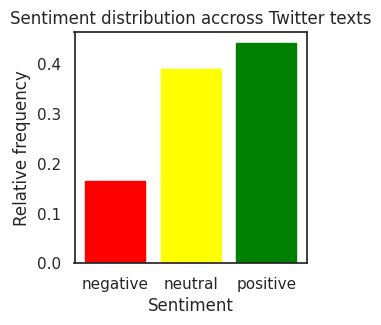

In [ ]:
data = df['sentiment']

# Calculate relative frequencies
relative_frequencies = data.value_counts(normalize=True)

# Plotting the histogram
plt.rcParams["figure.figsize"] = [3,3]
bars = plt.bar(relative_frequencies.index, relative_frequencies, width=0.8)

plt.title('Sentiment distribution accross Twitter texts')
plt.xlabel('Sentiment')
plt.ylabel('Relative frequency')
plt.xticks([-1, 0, 1])
plt.xticks((-1, 0, 1), ('negative', 'neutral', 'positive'))
bars[0].set_color('green')
bars[1].set_color('yellow')
bars[2].set_color('red')
plt.show()

###Sentiment distribution across Twitter texts
This bar chart shows the overall sentiment pattern in the entire dataset. Positive tweets form the largest proportion, followed by neutral tweets, while negative tweets are the least frequent. This indicates that, although customer service conversations often include issues, a substantial share of tweets still express satisfaction, appreciation, or positive engagement. Overall, the dataset is slightly skewed toward positive sentiment, suggesting a generally favorable tone in the collected Twitter texts.

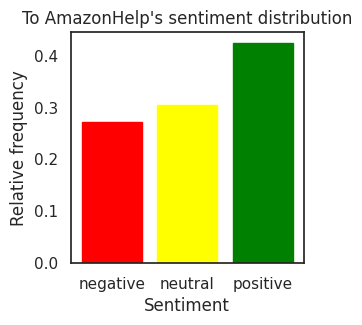

In [ ]:
toAmazon = df[df['original_text'].str.contains('Amazon')]
data = toAmazon['sentiment']

# Calculate relative frequencies
relative_frequencies = data.value_counts(normalize=True)

# Plotting the histogram
plt.rcParams["figure.figsize"] = [3,3]
to_amazon_bar = plt.bar(relative_frequencies.index, relative_frequencies, width=0.8)

# clean up the plot, add a title, color the bars, ...
plt.title('To AmazonHelp\'s sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Relative frequency')
plt.xticks([-1, 0, 1])
plt.xticks((-1, 0, 1), ('negative', 'neutral', 'positive'))
to_amazon_bar[0].set_color('green')
to_amazon_bar[1].set_color('yellow')
to_amazon_bar[2].set_color('red')
plt.show()

###To AmazonHelp’s sentiment distribution
This chart represents tweets addressed to AmazonHelp. Here, positive sentiment remains the largest category, but the proportion of negative tweets is noticeably higher than in the overall dataset. This suggests that when users directly contact AmazonHelp, they often do so to raise complaints or report problems, although many tweets still contain neutral or polite requests and positive feedback.

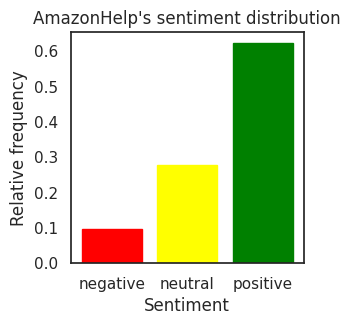

In [ ]:
amazonhelp = df[df['author_id'].str.contains('Amazon')]
data = amazonhelp['sentiment']

# Calculate relative frequencies
relative_frequencies = data.value_counts(normalize=True)

# Plotting the histogram
plt.rcParams["figure.figsize"] = [3,3]
amazon_bar = plt.bar(relative_frequencies.index, relative_frequencies, width=0.8)

# clean up the plot, add a title, color the bars, ...
plt.title('AmazonHelp\'s sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Relative frequency')
plt.xticks([-1, 0, 1])
plt.xticks((-1, 0, 1), ('negative', 'neutral', 'positive'))
amazon_bar[0].set_color('green')
amazon_bar[1].set_color('yellow')
amazon_bar[2].set_color('red')
plt.show()

###AmazonHelp’s sentiment distribution
This chart shows tweets posted by the AmazonHelp account itself. Positive sentiment dominates strongly, while negative sentiment is very low. This indicates that AmazonHelp’s responses are generally polite, supportive, and solution-oriented, reflecting a customer-service-focused communication style aimed at resolving issues and maintaining a positive brand image.

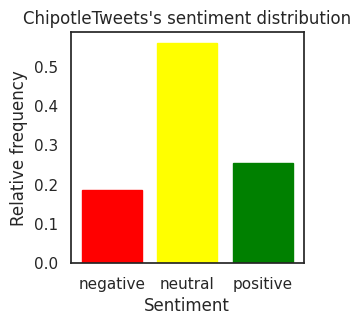

In [ ]:
to_chipotletweets = df[df['original_text'].str.contains('Chipotle')]
data = to_chipotletweets['sentiment']

# Calculate relative frequencies
relative_frequencies = data.value_counts(normalize=True)

# Plotting the histogram
plt.rcParams["figure.figsize"] = [3,3]
to_chipotle_bar = plt.bar(relative_frequencies.index, relative_frequencies, width=0.8)

# clean up the plot, add a title, color the bars, ...
plt.title('ChipotleTweets\'s sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Relative frequency')
plt.xticks([-1, 0, 1])
plt.xticks((-1, 0, 1), ('negative', 'neutral', 'positive'))
to_chipotle_bar[0].set_color('yellow')
to_chipotle_bar[1].set_color('green')
to_chipotle_bar[2].set_color('red')
plt.show()

###ChipotleTweets’ sentiment distribution (tweets to Chipotle)
This chart shows that neutral sentiment is the most dominant, followed by positive sentiment, while negative sentiment is the least frequent. This pattern suggests that most users contacting Chipotle are making neutral inquiries, routine requests, or general comments rather than expressing strong emotions. The moderate level of positive tweets indicates customer appreciation and satisfaction, whereas the smaller proportion of negative tweets reflects comparatively fewer complaints or dissatisfaction cases.

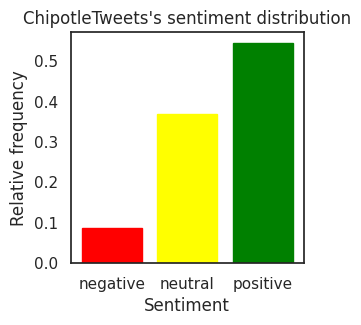

In [ ]:
chipotletweets = df[df['author_id'].str.contains('Chipotle')]
data = chipotletweets['sentiment']

# Calculate relative frequencies
relative_frequencies = data.value_counts(normalize=True)

# Plotting the histogram
plt.rcParams["figure.figsize"] = [3,3]
chipotle_bar = plt.bar(relative_frequencies.index, relative_frequencies, width=0.8)

# clean up the plot, add a title, color the bars, ...
plt.title('ChipotleTweets\'s sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Relative frequency')
plt.xticks([-1, 0, 1])
plt.xticks((-1, 0, 1), ('negative', 'neutral', 'positive'))
chipotle_bar[0].set_color('green')
chipotle_bar[1].set_color('yellow')
chipotle_bar[2].set_color('red')
plt.show()

###ChipotleTweets’ sentiment distribution (tweets by Chipotle)
This chart indicates that positive sentiment clearly dominates, with neutral sentiment in the second position and negative sentiment being very low. This implies that Chipotle’s official tweets are largely positive, friendly, and customer-oriented in tone. Such a distribution reflects a brand communication strategy focused on promoting goodwill, responding politely, and maintaining a positive public image.

In [ ]:
text = " ".join(chat for chat in df.text_nlst)
print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 77937 words in the combination of all tweets.


In [ ]:
#create list with all the company names
companies_lst = companies['author_id']
company_lst = sorted(set(companies_lst))

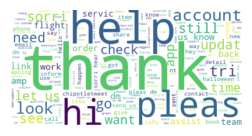

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)

# create all company names list
stopwords.update(company_lst)
stopwords.update(['https', 'co'])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

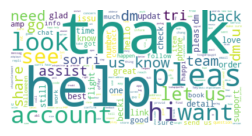

In [ ]:
pos_tweets = df[df['sentiment'] == 1]
pos_text = " ".join(chat for chat in pos_tweets.text_nlst)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(pos_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

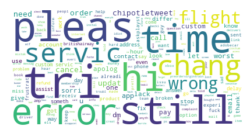

In [ ]:
# Next, for negative tweets:
neg_tweets = df[df['sentiment'] == -1]
neg_text = " ".join(chat for chat in neg_tweets.text_nlst)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(neg_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Word clouds
A word cloud is a visual representation of text data where the size of each word corresponds to its frequency or importance. It provides a quick and intuitive summary of the most prominent terms within a body of text. In this section, we will compare 3 word clouds: across all tweets, positive and negative tweets.


### Exercise 1 - Interpreting word clouds


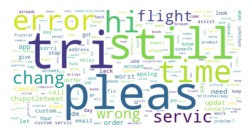

In [ ]:
neg_tweets = df[df['sentiment'] == -1]
neg_text = " ".join(chat for chat in neg_tweets.text_nlst)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(neg_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Exercise 2 - Using Multinomial Naive Bayes for sentiment analysis


In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb = MultinomialNB()

In [ ]:
mnb.fit(X_train_vec,y_train_encoded)
y_pred_mnb = mnb.predict(X_test_vec)
print("Accuracy:\n", round(accuracy_score(y_test_encoded, y_pred_mnb)*100,2), '%')

Accuracy:
 62.62 %
